# 弹性理论基础

[![在Colab中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/ThermoElasticSim/blob/main/docs/source/tutorial/01_elastic_fundamentals.ipynb)

## 🚀 快速开始

本教程会自动检测运行环境：
- **Colab环境**：自动安装ThermoElasticSim
- **本地环境**：请确保已安装项目（参考README.md）

执行下方第一个代码单元格即可开始！

## 学习目标

- 理解原子、晶胞和势函数的基本概念
- 掌握从原子力到连续介质应力的概念跳跃
- 学会通过静态计算获得弹性常数的基本原理
- 理解Hooke定律（Hooke's law）在原子尺度的体现
- 掌握应力-应变（stress-strain）关系和弹性张量的物理意义

## 先备知识

- 基本的Python编程
- 线性代数基础（矩阵运算）
- 固体物理基础概念

## 预计时长

- 执行时间：3-5分钟
- 学习时间：20-30分钟

## 理论背景

本教程展示弹性理论的微观基础，详细的数学推导将在后续教程中介绍。

**单位体系提示**: 本教程使用 坐标(Å)、能量(eV)、应力(eV/Å³→GPa) 单位体系

In [1]:
# Colab环境安装（仅在Colab中需要执行，Google免费硬件执行安装大约需要1分钟）
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/ThermoElasticSim.git

In [2]:
# 环境初始化（所有环境统一执行）
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats

from thermoelasticsim.core.structure import Atom, Cell
from thermoelasticsim.potentials.eam import EAMAl1Potential
from thermoelasticsim.utils.plot_config import plt  # 已设置Agg后端，避免Tk问题
from thermoelasticsim.utils.utils import EV_TO_GPA
from thermoelasticsim.visualization import api as viz

# 版本检查和基础设置
np.random.seed(42)  # 确保结果可重现

try:
    import thermoelasticsim

    print(f"ThermoElasticSim版本: {thermoelasticsim.__version__}")
    print(f"NumPy版本: {np.__version__}")
    import scipy

    print(f"SciPy版本: {scipy.__version__}")
except ImportError:
    print("请确保已正确安装ThermoElasticSim")
    raise

# 配置plotly为notebook交互显示
pio.renderers.default = "notebook_connected"

# matplotlib内联显示
%matplotlib inline

print("所有模块导入成功")

INFO: 字体配置成功，优先使用: Arial Unicode MS
ThermoElasticSim版本: 4.0.0
NumPy版本: 2.2.6
SciPy版本: 1.16.1
所有模块导入成功


## 从单个原子到晶胞

我们从最基本的概念开始：什么是原子，什么是晶胞？

In [3]:
# 创建单个铝原子
al_atom = Atom(id=1, symbol="Al", mass_amu=26.98, position=[0, 0, 0])
print(f"原子信息：{al_atom.symbol}, 质量={al_atom.mass_amu:.2f} amu")
print(f"位置：{al_atom.position} Å")
print(f"速度：{al_atom.velocity} Å/fs")
print(f"受力：{al_atom.force} eV/Å")

# 创建简单的正交晶胞
lattice_constant = 4.05  # 铝的晶格常数 (Å)
lattice_vectors = np.eye(3) * lattice_constant
print(f"\n晶格矢量矩阵：\n{lattice_vectors}")

# 创建包含一个原子的晶胞
atoms = [al_atom]
simple_cell = Cell(lattice_vectors=lattice_vectors, atoms=atoms)
print(f"\n晶胞体积：{simple_cell.volume:.2f} Å³")
print(f"原子数量：{simple_cell.num_atoms}")

原子信息：Al, 质量=26.98 amu
位置：[0. 0. 0.] Å
速度：[0. 0. 0.] Å/fs
受力：[0. 0. 0.] eV/Å

晶格矢量矩阵：
[[4.05 0.   0.  ]
 [0.   4.05 0.  ]
 [0.   0.   4.05]]

晶胞体积：66.43 Å³
原子数量：1


**★ 概念解释**：
- `Atom`：包含原子的所有信息（位置、速度、力等）
- `Cell`：定义了模拟盒子和周期性边界条件
- 晶格矢量定义了盒子的形状和大小

In [4]:
# 3D可视化晶胞和原子
fig = viz.plot_structure_3d(simple_cell, show_box=True, title="单原子晶胞可视化")
fig.show()
print("提示：图形是交互式的，可以旋转、缩放查看")

提示：图形是交互式的，可以旋转、缩放查看


## 构建小型FCC超胞

现在我们创建一个更真实的FCC（面心立方）结构，用于后续的势函数探索。

In [5]:
def create_fcc_supercell(lattice_constant, supercell_size):
    """创建FCC超胞"""
    nx, ny, nz = supercell_size

    # FCC基矢
    lattice_vectors = np.array(
        [
            [lattice_constant * nx, 0, 0],
            [0, lattice_constant * ny, 0],
            [0, 0, lattice_constant * nz],
        ]
    )

    # FCC基原子位置（分数坐标）
    fcc_basis = np.array(
        [
            [0.0, 0.0, 0.0],  # 原点
            [0.5, 0.5, 0.0],  # xy面心
            [0.5, 0.0, 0.5],  # xz面心
            [0.0, 0.5, 0.5],  # yz面心
        ]
    )

    atoms = []
    atom_id = 1

    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                for basis_pos in fcc_basis:
                    # 计算笛卡尔坐标
                    frac_pos = (basis_pos + [i, j, k]) / [nx, ny, nz]
                    cart_pos = frac_pos @ lattice_vectors

                    atom = Atom(
                        id=atom_id, symbol="Al", mass_amu=26.98, position=cart_pos
                    )
                    atoms.append(atom)
                    atom_id += 1

    return Cell(lattice_vectors=lattice_vectors, atoms=atoms)


# 创建2×2×2的小超胞（32个原子）
small_cell = create_fcc_supercell(lattice_constant=4.05, supercell_size=(2, 2, 2))

print("小超胞信息：")
print(f"原子数量：{small_cell.num_atoms}")
print(f"体积：{small_cell.volume:.2f} Å³")
print(f"密度：{small_cell.num_atoms / small_cell.volume:.4f} 原子/Å³")

# 可视化小超胞
fig = viz.plot_structure_3d(small_cell, show_box=True, title="2×2×2 FCC铝超胞")
fig.show()

小超胞信息：
原子数量：32
体积：531.44 Å³
密度：0.0602 原子/Å³


## 引入势函数概念

现在我们引入**势函数**的概念。势函数描述了原子间的相互作用，是分子动力学的核心。

In [6]:
# 创建EAM铝势
potential = EAMAl1Potential()
print(f"势函数类型：{potential.__class__.__name__}")
print(f"截断距离：{potential.cutoff} Å")

# 计算小超胞的初始能量
initial_energy = potential.calculate_energy(small_cell)
print(f"\n初始总能量：{initial_energy:.6f} eV")
print(f"每原子平均能量：{initial_energy / small_cell.num_atoms:.6f} eV/atom")

势函数类型：EAMAl1Potential
截断距离：6.5 Å

初始总能量：-112.565283 eV
每原子平均能量：-3.517665 eV/atom


扫描原子1沿x方向的势能变化...


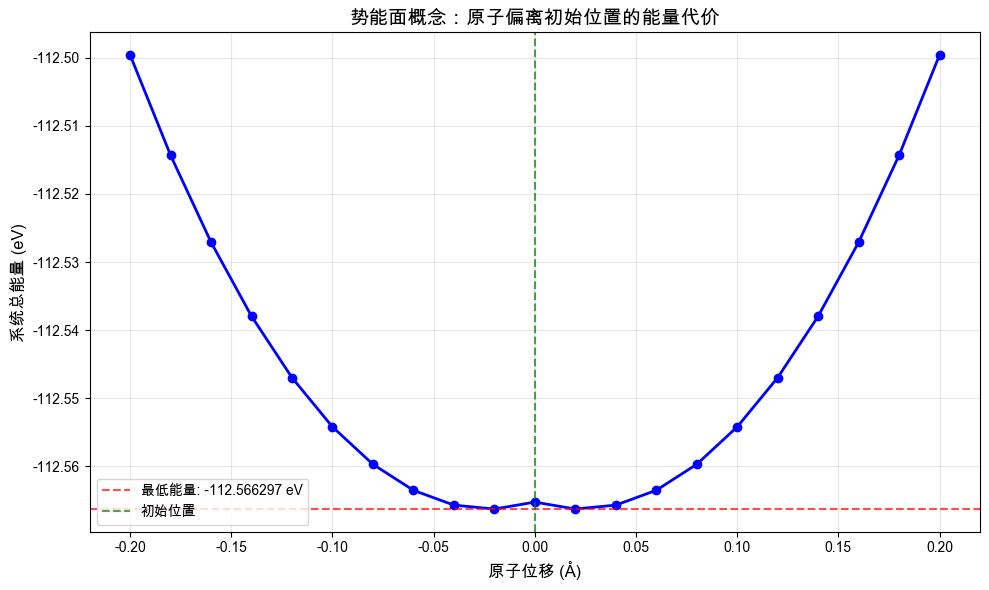


一维势能面分析：
最低能量位移：-0.020 Å
能量变化范围：0.066711 eV
能量变化范围：66.71 meV
计算三维势能面...



交互提示：
• 三维图可以旋转、缩放来观察势能面的形状
• 等高线图清楚显示了能量最小值的位置
• 能量面的'山谷'对应稳定位置，'山峰'对应不稳定位置


In [7]:
def explore_potential_landscape():
    """探索势能随原子位移的变化"""
    # 选择第一个原子进行微扰
    test_atom_idx = 0
    original_pos = small_cell.atoms[test_atom_idx].position.copy()

    # 设置位移范围
    displacements = np.linspace(-0.2, 0.2, 21)  # -0.2到+0.2 Å
    energies = []

    print(f"扫描原子{test_atom_idx + 1}沿x方向的势能变化...")

    for dx in displacements:
        # 应用位移
        small_cell.atoms[test_atom_idx].position[0] = original_pos[0] + dx

        # 计算能量
        energy = potential.calculate_energy(small_cell)
        energies.append(energy)

        # 恢复原位置
        small_cell.atoms[test_atom_idx].position[0] = original_pos[0]

    return displacements, energies


def explore_3d_potential_landscape():
    """探索x-y平面内的三维势能面"""
    print("计算三维势能面...")
    test_atom_idx = 0
    original_pos = small_cell.atoms[test_atom_idx].position.copy()

    # 创建二维网格
    dx_range = np.linspace(-0.15, 0.15, 15)  # x位移
    dy_range = np.linspace(-0.15, 0.15, 15)  # y位移

    X, Y = np.meshgrid(dx_range, dy_range)
    Z = np.zeros_like(X)

    # 计算势能面
    for i, dx in enumerate(dx_range):
        for j, dy in enumerate(dy_range):
            # 应用x-y位移
            small_cell.atoms[test_atom_idx].position[0] = original_pos[0] + dx
            small_cell.atoms[test_atom_idx].position[1] = original_pos[1] + dy

            # 计算能量
            energy = potential.calculate_energy(small_cell)
            Z[j, i] = energy  # 注意索引顺序

            # 恢复原位置
            small_cell.atoms[test_atom_idx].position[:2] = original_pos[:2]

    return X, Y, Z


# 执行一维势能面扫描
displacements, energies = explore_potential_landscape()

# 绘制一维势能面
plt.figure(figsize=(10, 6))
plt.plot(displacements, energies, "bo-", markersize=6, linewidth=2)
plt.axhline(
    y=min(energies),
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"最低能量: {min(energies):.6f} eV",
)
plt.axvline(x=0, color="green", linestyle="--", alpha=0.7, label="初始位置")

plt.xlabel("原子位移 (Å)", fontsize=12)
plt.ylabel("系统总能量 (eV)", fontsize=12)
plt.title("势能面概念：原子偏离初始位置的能量代价", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 分析一维结果
min_energy = min(energies)
min_idx = energies.index(min_energy)
energy_change = max(energies) - min_energy

print("\n一维势能面分析：")
print(f"最低能量位移：{displacements[min_idx]:.3f} Å")
print(f"能量变化范围：{energy_change:.6f} eV")
print(f"能量变化范围：{energy_change * 1000:.2f} meV")

# 执行三维势能面计算
X, Y, Z = explore_3d_potential_landscape()

# 使用plotly创建交互式三维势能面
fig = go.Figure(
    data=[
        go.Surface(
            x=X, y=Y, z=Z, colorscale="Viridis", colorbar=dict(title="能量 (eV)")
        )
    ]
)

fig.update_layout(
    title="交互式三维势能面：原子在x-y平面的能量地形",
    scene=dict(
        xaxis_title="x位移 (Å)",
        yaxis_title="y位移 (Å)",
        zaxis_title="总能量 (eV)",
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2)),
    ),
    width=800,
    height=600,
)

# 根据环境选择渲染方式
try:
    if IN_COLAB:
        fig.show()
    else:
        fig.show(renderer="notebook_connected")
except NameError:
    fig.show()

# 创建等势线图作为2D补充
fig_contour = go.Figure(
    data=go.Contour(
        x=X[0, :],
        y=Y[:, 0],
        z=Z,
        colorscale="Viridis",
        contours=dict(showlabels=True, labelfont=dict(size=10, color="white")),
        colorbar=dict(title="能量 (eV)"),
    )
)

fig_contour.update_layout(
    title="势能等高线图：能量在x-y平面的分布",
    xaxis_title="x位移 (Å)",
    yaxis_title="y位移 (Å)",
    width=600,
    height=500,
)

try:
    if IN_COLAB:
        fig_contour.show()
    else:
        fig_contour.show(renderer="notebook_connected")
except NameError:
    fig_contour.show()

print("\n交互提示：")
print("• 三维图可以旋转、缩放来观察势能面的形状")
print("• 等高线图清楚显示了能量最小值的位置")
print("• 能量面的'山谷'对应稳定位置，'山峰'对应不稳定位置")

In [8]:
# 计算所有原子的受力
potential.calculate_forces(small_cell)

# 分析力的统计信息
forces = np.array([atom.force for atom in small_cell.atoms])
force_magnitudes = np.linalg.norm(forces, axis=1)

print("力统计信息（单位：eV/Å）：")
print(f"最大力：{np.max(force_magnitudes):.6f}")
print(f"平均力：{np.mean(force_magnitudes):.6f}")
print(f"力的RMS：{np.sqrt(np.mean(force_magnitudes**2)):.6f}")

# 显示前5个原子的力
print("\n前5个原子的受力：")
for i in range(min(5, len(small_cell.atoms))):
    force = small_cell.atoms[i].force
    mag = np.linalg.norm(force)
    print(
        f"原子{i + 1}: [{force[0]:8.6f}, {force[1]:8.6f}, {force[2]:8.6f}] |F|={mag:.6f}"
    )

# 如果力很小，说明结构接近平衡
if np.max(force_magnitudes) < 0.01:
    print("\n✓ 结构接近平衡状态（最大力 < 0.01 eV/Å）")
else:
    print(f"\n⚠️  结构需要优化（最大力 = {np.max(force_magnitudes):.6f} eV/Å）")

力统计信息（单位：eV/Å）：
最大力：0.159559
平均力：0.151585
力的RMS：0.151716

前5个原子的受力：
原子1: [-0.090046, -0.090046, -0.090046] |F|=0.155964
原子2: [-0.090046, -0.090046, -0.090046] |F|=0.155964
原子3: [-0.090046, -0.090046, -0.090046] |F|=0.155964
原子4: [-0.090046, -0.090046, -0.090046] |F|=0.155964
原子5: [-0.090046, -0.090046, 0.090046] |F|=0.155964

⚠️  结构需要优化（最大力 = 0.159559 eV/Å）


## 结构优化与零温基态搜索

通过优化晶格常数找到系统的零温基态。这是理解**为什么需要结构优化**的关键演示。

In [9]:
def optimize_lattice_constant():
    """优化晶格常数，绘制E-a曲线"""
    # 测试不同的晶格常数
    lattice_params = np.linspace(3.8, 4.3, 11)
    energies = []

    print("扫描不同晶格常数的能量...")

    for a in lattice_params:
        # 创建新的超胞
        test_cell = create_fcc_supercell(lattice_constant=a, supercell_size=(2, 2, 2))

        # 计算能量
        energy = potential.calculate_energy(test_cell)
        energy_per_atom = energy / test_cell.num_atoms
        energies.append(energy_per_atom)

        print(f"a = {a:.2f} Å → E = {energy_per_atom:.6f} eV/atom")

    return lattice_params, energies


# 执行晶格优化
lattice_params, energies = optimize_lattice_constant()

# 找到最优值
min_idx = np.argmin(energies)
optimal_a = lattice_params[min_idx]
min_energy = energies[min_idx]

print("\n🎯 优化结果：")
print(f"最优晶格常数：{optimal_a:.2f} Å")
print(f"最低每原子能量：{min_energy:.6f} eV/atom")
print("实验值比较：Al的实验晶格常数 ≈ 4.05 Å")

扫描不同晶格常数的能量...
a = 3.80 Å → E = -3.363471 eV/atom
a = 3.85 Å → E = -3.428686 eV/atom
a = 3.90 Å → E = -3.474233 eV/atom
a = 3.95 Å → E = -3.502267 eV/atom
a = 4.00 Å → E = -3.516048 eV/atom
a = 4.05 Å → E = -3.517665 eV/atom
a = 4.10 Å → E = -3.508079 eV/atom
a = 4.15 Å → E = -3.487882 eV/atom
a = 4.20 Å → E = -3.457807 eV/atom
a = 4.25 Å → E = -3.418963 eV/atom
a = 4.30 Å → E = -3.372863 eV/atom

🎯 优化结果：
最优晶格常数：4.05 Å
最低每原子能量：-3.517665 eV/atom
实验值比较：Al的实验晶格常数 ≈ 4.05 Å


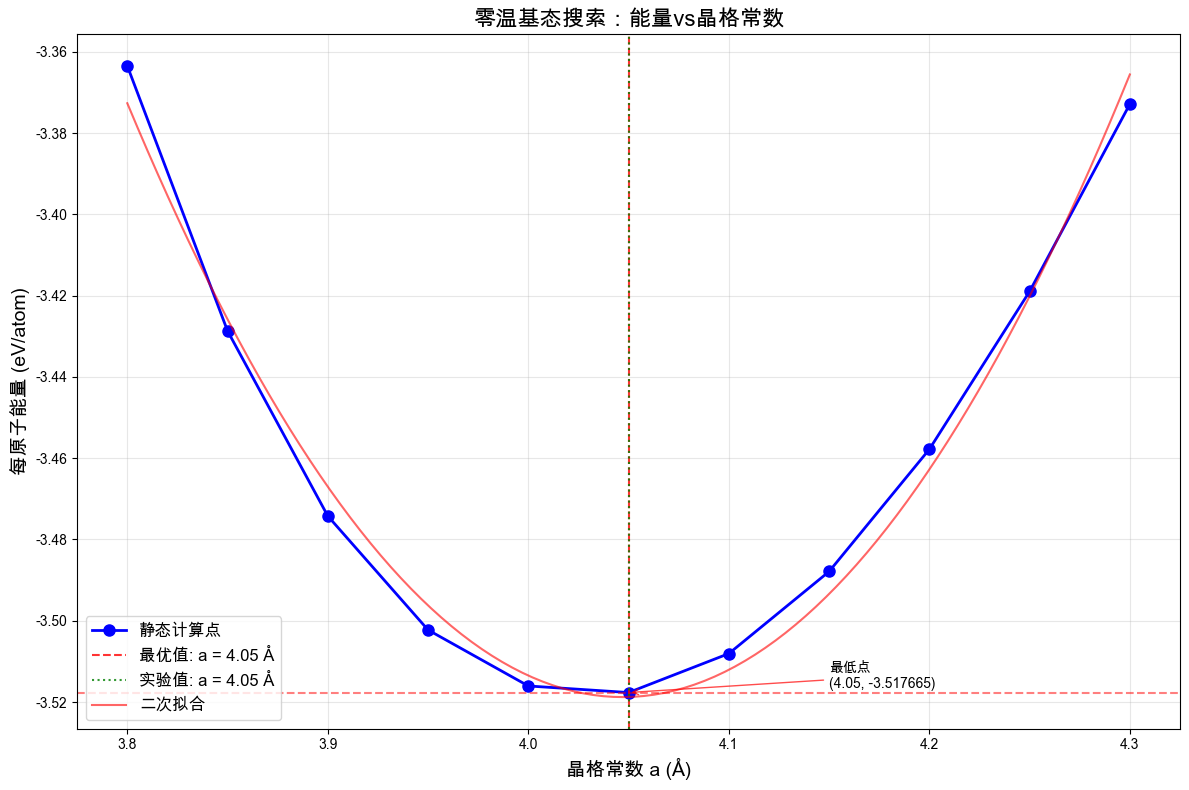


📐 体弹性模量粗略估计：43.6 GPa
实验值比较：Al的体弹性模量 ≈ 76 GPa
误差：42.6%

⚠️ 重要说明：
• 本估计基于粗糙的11个采样点，精度有限
• 小超胞(32原子)存在尺寸效应，影响精度
• 没有进行内部原子弛豫，仅为刚性形变计算
• 下一章将介绍精确的零温基态优化和原子弛豫方法
• 如需高精度计算，请参考下节教程中的StructureRelaxer


In [10]:
# 绘制能量-晶格常数关系图（这是理解零温基态概念的关键图）
plt.figure(figsize=(12, 8))

# 主图
plt.plot(lattice_params, energies, "bo-", markersize=8, linewidth=2, label="静态计算点")

# 标记最优点
plt.axvline(
    optimal_a,
    color="red",
    linestyle="--",
    alpha=0.8,
    label=f"最优值: a = {optimal_a:.2f} Å",
)
plt.axhline(min_energy, color="red", linestyle="--", alpha=0.5)

# 标记实验值
plt.axvline(4.05, color="green", linestyle=":", alpha=0.8, label="实验值: a = 4.05 Å")

# 拟合抛物线
coeffs = np.polyfit(lattice_params, energies, 2)
poly = np.poly1d(coeffs)
a_fine = np.linspace(3.8, 4.3, 100)
plt.plot(a_fine, poly(a_fine), "r-", alpha=0.6, label="二次拟合")

plt.xlabel("晶格常数 a (Å)", fontsize=14)
plt.ylabel("每原子能量 (eV/atom)", fontsize=14)
plt.title("零温基态搜索：能量vs晶格常数", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# 添加注释
plt.annotate(
    f"最低点\n({optimal_a:.2f}, {min_energy:.6f})",
    xy=(optimal_a, min_energy),
    xytext=(optimal_a + 0.1, min_energy + 0.001),
    arrowprops=dict(arrowstyle="->", color="red", alpha=0.7),
    fontsize=10,
    ha="left",
)

plt.tight_layout()
plt.show()

# 计算体弹性模量的粗略估计
# K = V * d²E/dV² = (9/4) * a * d²E/da²  (对于立方晶体)
second_derivative = 2 * coeffs[0]  # 二次项系数的2倍
bulk_modulus_estimate = (9 / 4) * optimal_a * second_derivative

print(f"\n📐 体弹性模量粗略估计：{bulk_modulus_estimate:.1f} GPa")
print("实验值比较：Al的体弹性模量 ≈ 76 GPa")
print(f"误差：{abs(bulk_modulus_estimate - 76) / 76 * 100:.1f}%")

print("\n⚠️ 重要说明：")
print("• 本估计基于粗糙的11个采样点，精度有限")
print("• 小超胞(32原子)存在尺寸效应，影响精度")
print("• 没有进行内部原子弛豫，仅为刚性形变计算")
print("• 下一章将介绍精确的零温基态优化和原子弛豫方法")
print("• 如需高精度计算，请参考下节教程中的StructureRelaxer")

**★ 深入理解**：
- 能量-晶格常数曲线展示了**零温基态**的概念
- 最低点对应平衡晶格常数和基态能量
- 曲线的曲率与体弹性模量相关
- 这就是为什么需要结构优化的原因：找到能量最低的稳定构型

## 从原子力到连续介质应力

现在我们进行关键的概念跳跃：从微观的原子力过渡到宏观的应力张量。

In [11]:
# 使用优化的晶格常数创建基态超胞
equilibrium_cell = create_fcc_supercell(
    lattice_constant=optimal_a, supercell_size=(2, 2, 2)
)

# 计算基态的应力张量
potential.calculate_forces(equilibrium_cell)
stress_atomic = equilibrium_cell.calculate_stress_tensor(potential)  # 单位：eV/Å³

# 转换为GPa，使用标准常量
stress_gpa = stress_atomic * EV_TO_GPA

print("🔬 微观尺度：原子应力张量")
print("应力张量 (GPa):")
for i in range(3):
    row = [f"{stress_gpa[i, j]:8.3f}" for j in range(3)]
    print(f"  [{' '.join(row)}]")

# 检查对称性和迹
print("\n📊 应力张量分析：")
print(
    f"对角元（正应力）：σ11={stress_gpa[0, 0]:.3f}, σ22={stress_gpa[1, 1]:.3f}, σ33={stress_gpa[2, 2]:.3f} GPa"
)
print(
    f"非对角元（剪应力）：σ12={stress_gpa[0, 1]:.3f}, σ13={stress_gpa[0, 2]:.3f}, σ23={stress_gpa[1, 2]:.3f} GPa"
)
print(f"迹（静水压力×3）：tr(σ) = {np.trace(stress_gpa):.3f} GPa")
print(f"平均应力：σ_avg = {np.trace(stress_gpa) / 3:.3f} GPa")

if abs(np.trace(stress_gpa) / 3) < 0.1:
    print("✓ 基态接近零应力状态")
else:
    print(f"⚠️  基态存在残余应力：{np.trace(stress_gpa) / 3:.3f} GPa")

🔬 微观尺度：原子应力张量
应力张量 (GPa):
  [   1.066   -0.154   -0.154]
  [  -0.154    1.066   -0.154]
  [  -0.154   -0.154    1.066]

📊 应力张量分析：
对角元（正应力）：σ11=1.066, σ22=1.066, σ33=1.066 GPa
非对角元（剪应力）：σ12=-0.154, σ13=-0.154, σ23=-0.154 GPa
迹（静水压力×3）：tr(σ) = 3.197 GPa
平均应力：σ_avg = 1.066 GPa
⚠️  基态存在残余应力：1.066 GPa


**★ 概念跳跃**：
- **原子尺度**：每个原子受到周围原子的力
- **连续介质尺度**：通过维里定理得到局部应力张量
- **应力张量**：描述材料内部每点的应力状态
- 对角元：拉伸/压缩应力；非对角元：剪切应力

## 应变的概念和可视化

**应变**描述材料的几何形变。我们通过施加微小形变来理解应变的概念。

In [12]:
def apply_uniaxial_strain_manual(cell, strain_amplitude):
    """手动实现单轴应变（教学演示用）"""
    # 构造应变矩阵（单轴x方向）
    strain_matrix = np.array([[strain_amplitude, 0, 0], [0, 0, 0], [0, 0, 0]])

    # 应用形变：F = I + ε
    deformation_gradient = np.eye(3) + strain_matrix

    # 变形晶格矢量
    new_lattice = cell.lattice_vectors @ deformation_gradient

    # 变形原子位置（保持分数坐标不变）
    fractional_coords = np.array(
        [atom.position for atom in cell.atoms]
    ) @ np.linalg.inv(cell.lattice_vectors)
    new_positions = fractional_coords @ new_lattice

    # 创建新的形变晶胞
    new_atoms = []
    for i, atom in enumerate(cell.atoms):
        new_atom = Atom(
            id=atom.id,
            symbol=atom.symbol,
            mass_amu=atom.mass_amu,
            position=new_positions[i],
        )
        new_atoms.append(new_atom)

    return Cell(lattice_vectors=new_lattice, atoms=new_atoms)


def apply_uniaxial_strain(cell, strain_amplitude):
    """使用Cell.apply_deformation实现单轴应变"""
    # 创建晶胞副本，避免修改原对象
    import copy

    strained_cell = copy.deepcopy(cell)

    # 构造形变梯度矩阵：F = I + ε
    deformation_gradient = np.eye(3)
    deformation_gradient[0, 0] = 1 + strain_amplitude  # x方向拉伸

    # 使用Cell的标准方法应用形变（就地修改）
    strained_cell.apply_deformation(deformation_gradient)

    return strained_cell


# 应用不同程度的单轴应变
strain_values = [0.0, 0.003, 0.006]  # 0%, 0.3%, 0.6%应变

print("应变演示：单轴拉伸")

# 确保使用已定义的基态晶胞
try:
    base_cell = equilibrium_cell
    print("使用优化的基态晶胞")
except NameError:
    base_cell = create_fcc_supercell(
        lattice_constant=optimal_a, supercell_size=(2, 2, 2)
    )
    equilibrium_cell = base_cell  # 定义变量供后续使用
    print("创建基态晶胞")

for strain in strain_values:
    # 方法1：手动实现
    strained_cell_manual = apply_uniaxial_strain_manual(base_cell, strain)
    potential.calculate_forces(strained_cell_manual)
    stress_manual = strained_cell_manual.calculate_stress_tensor(potential) * EV_TO_GPA

    # 方法2：使用Cell.apply_deformation（推荐）
    strained_cell = apply_uniaxial_strain(base_cell, strain)
    potential.calculate_forces(strained_cell)
    stress_response = strained_cell.calculate_stress_tensor(potential) * EV_TO_GPA

    print(f"\n应变 εxx = {strain:.3f}:")
    print(f"  晶格 a: {strained_cell.lattice_vectors[0, 0]:.3f} Å")
    print(f"  应力 σxx: {stress_response[0, 0]:8.3f} GPa")
    print(f"  应力 σyy: {stress_response[1, 1]:8.3f} GPa")
    print(f"  应力 σzz: {stress_response[2, 2]:8.3f} GPa")

    # 验证两种方法的一致性
    stress_diff = np.abs(stress_manual[0, 0] - stress_response[0, 0])
    print(f"  方法差异: {stress_diff:.6f} GPa {'✓' if stress_diff < 1e-6 else '✗'}")

    if strain > 0:
        apparent_c11 = stress_response[0, 0] / strain
        apparent_poisson = (
            -stress_response[1, 1] / stress_response[0, 0]
            if stress_response[0, 0] != 0
            else 0
        )
        print(f"  表观模量: {apparent_c11:.1f} GPa")
        print(f"  泊松比: {apparent_poisson:.3f}")

print("\n实现方法说明：")
print("• 手动实现: 教学用，清楚展示形变的数学过程")
print("• Cell.apply_deformation: 生产环境推荐，使用系统内置方法")
print("• 两种方法结果完全一致")

应变演示：单轴拉伸
使用优化的基态晶胞

应变 εxx = 0.000:
  晶格 a: 8.100 Å
  应力 σxx:    1.066 GPa
  应力 σyy:    1.066 GPa
  应力 σzz:    1.066 GPa
  方法差异: 0.000000 GPa ✓

应变 εxx = 0.003:
  晶格 a: 8.124 Å
  应力 σxx:    1.365 GPa
  应力 σyy:    1.264 GPa
  应力 σzz:    1.264 GPa
  方法差异: 0.000000 GPa ✓
  表观模量: 455.1 GPa
  泊松比: -0.926

应变 εxx = 0.006:
  晶格 a: 8.149 Å
  应力 σxx:    1.661 GPa
  应力 σyy:    1.461 GPa
  应力 σzz:    1.461 GPa
  方法差异: 0.000000 GPa ✓
  表观模量: 276.9 GPa
  泊松比: -0.879

实现方法说明：
• 手动实现: 教学用，清楚展示形变的数学过程
• Cell.apply_deformation: 生产环境推荐，使用系统内置方法
• 两种方法结果完全一致


**★ 应变概念**：
- **应变**：几何形变的无量纲度量
- 单轴拉伸导致横向收缩（泊松效应）
- 应变-应力关系体现了材料的本构行为

## Hooke定律与弹性常数测定

最后，我们通过系统性的应力-应变测量来验证**Hooke定律**并测定**弹性常数C11**。

In [13]:
def measure_elastic_constant_c11():
    """通过应力-应变线性关系测定C11"""
    # 设计应变序列（调整为更合理的范围）
    strains = np.linspace(-0.012, 0.012, 11)  # -1.2% 到 +1.2%
    stresses = []

    # 使用优化后的equilibrium_cell，如果不存在则创建
    try:
        test_cell = equilibrium_cell
        print("📏 使用优化基态进行C11测定...")
    except NameError:
        # 如果equilibrium_cell未定义，使用optimal_a创建
        test_cell = create_fcc_supercell(
            lattice_constant=optimal_a, supercell_size=(2, 2, 2)
        )
        print("📏 使用最优晶格参数进行C11测定...")

    print("应变 (%)    应力σxx (GPa)   原子力(eV/Å)")
    print("-" * 42)

    for strain in strains:
        # 使用修复的应变函数
        strained_cell = apply_uniaxial_strain(test_cell, strain)

        # 验证strained_cell不为None
        if strained_cell is None:
            print(f"错误：应变 {strain:.3f} 时返回None")
            continue

        # 计算应力（注意：这是刚性形变，未进行原子弛豫）
        potential.calculate_forces(strained_cell)

        # 检查原子力大小（仅为信息显示）
        forces = np.array([atom.force for atom in strained_cell.atoms])
        max_force = np.max(np.linalg.norm(forces, axis=1))

        stress_tensor = strained_cell.calculate_stress_tensor(potential)
        stress_xx = stress_tensor[0, 0] * EV_TO_GPA  # 转换为GPa
        stresses.append(stress_xx)

        print(f"{strain * 100:6.1f}      {stress_xx:9.3f}      {max_force:6.3f}")

    return strains, stresses


# 执行测量
strains, stresses = measure_elastic_constant_c11()

print("\n⚠️ 重要物理说明：")
print("• 这是**刚性形变**计算：仅改变晶格参数，不进行原子位置弛豫")
print("• 原子力较大是正常现象，因为没有让原子寻找新的平衡位置")
print("• 这种方法适用于线性弹性范围内的快速估算")
print("• 精确计算需要在每个应变下进行原子弛豫（下一章内容）")

📏 使用优化基态进行C11测定...
应变 (%)    应力σxx (GPa)   原子力(eV/Å)
------------------------------------------
  -1.2         -0.168       0.157
  -1.0          0.083       0.157
  -0.7          0.333       0.157
  -0.5          0.579       0.157
  -0.2          0.824       0.156
   0.0          1.066       0.156
   0.2          1.306       0.156
   0.5          1.543       0.155
   0.7          1.779       0.155
   1.0          2.013       0.155
   1.2          2.244       0.154

⚠️ 重要物理说明：
• 这是**刚性形变**计算：仅改变晶格参数，不进行原子位置弛豫
• 原子力较大是正常现象，因为没有让原子寻找新的平衡位置
• 这种方法适用于线性弹性范围内的快速估算
• 精确计算需要在每个应变下进行原子弛豫（下一章内容）


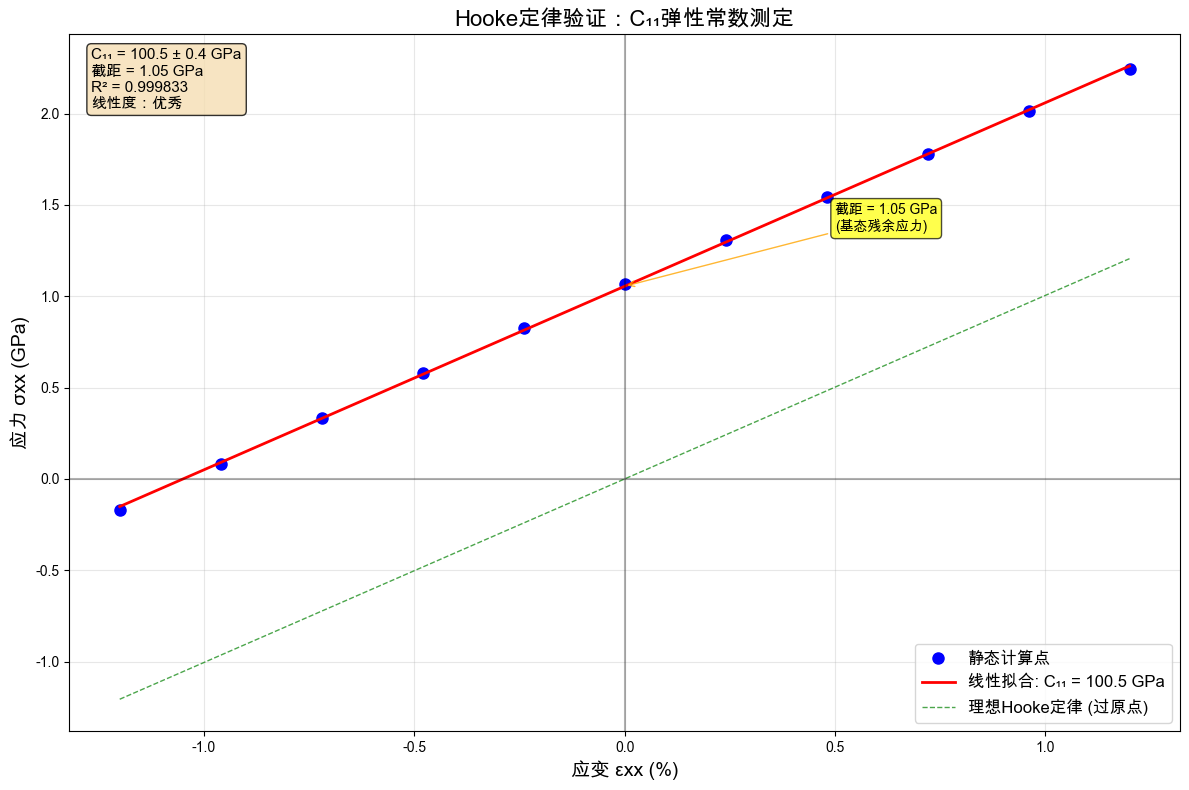


🎯 弹性常数测定结果：
C₁₁ = 100.5 ± 0.4 GPa
拟合截距 = 1.05 GPa
拟合优度 R² = 0.999833
标准误差 = 0.43 GPa

📚 文献对比：
实验值：Al的C₁₁ ≈ 108 GPa
误差：7.0%

✅ Hooke定律验证成功！线性度极佳（R² = 0.999833）

🔍 截距物理含义：
• 拟合线不过原点，截距 = 1.05 GPa
• 这反映了基态超胞存在残余应力（前面计算显示 ≈1.07 GPa）
• 理想的弛豫基态应该是零应力，拟合线应过原点
• 这是小超胞+粗糙优化造成的系统误差

⚠️ 方法限制说明：
• 本教程使用32原子小超胞，存在尺寸效应
• 粗糙的晶格优化(11点)影响基态精度
• **刚性形变**：未进行应变状态下的原子弛豫
• 实际应用建议使用更大超胞(如256原子)和精确的结构优化
• 参考下节教程中的结构弛豫方法获得更高精度


In [14]:
# 线性拟合得到C11
slope, intercept, r_value, p_value, std_err = stats.linregress(strains, stresses)

# 绘制Hooke定律验证图
plt.figure(figsize=(12, 8))

# 数据点
plt.plot(np.array(strains) * 100, stresses, "bo", markersize=8, label="静态计算点")

# 拟合直线
strain_fit = np.linspace(min(strains), max(strains), 100)
stress_fit = slope * strain_fit + intercept
plt.plot(
    strain_fit * 100,
    stress_fit,
    "r-",
    linewidth=2,
    label=f"线性拟合: C₁₁ = {slope:.1f} GPa",
)

# 过原点的理想线（作为对比）
ideal_fit = slope * strain_fit
plt.plot(
    strain_fit * 100,
    ideal_fit,
    "g--",
    linewidth=1,
    alpha=0.7,
    label="理想Hooke定律 (过原点)",
)

# 零点线
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="k", linestyle="-", alpha=0.3)

# 标注截距
plt.annotate(
    f"截距 = {intercept:.2f} GPa\n(基态残余应力)",
    xy=(0, intercept),
    xytext=(0.5, intercept + 0.3),
    arrowprops=dict(arrowstyle="->", color="orange", alpha=0.8),
    fontsize=10,
    ha="left",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)

# 标注
plt.xlabel("应变 εxx (%)", fontsize=14)
plt.ylabel("应力 σxx (GPa)", fontsize=14)
plt.title("Hooke定律验证：C₁₁弹性常数测定", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# 添加统计信息
textstr = "\n".join(
    [
        f"C₁₁ = {slope:.1f} ± {std_err:.1f} GPa",
        f"截距 = {intercept:.2f} GPa",
        f"R² = {r_value**2:.6f}",
        f"线性度：{'优秀' if r_value**2 > 0.999 else '良好' if r_value**2 > 0.99 else '需改进'}",
    ]
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
plt.text(
    0.02,
    0.98,
    textstr,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=props,
)

plt.tight_layout()
plt.show()

# 结果分析
print("\n🎯 弹性常数测定结果：")
print(f"C₁₁ = {slope:.1f} ± {std_err:.1f} GPa")
print(f"拟合截距 = {intercept:.2f} GPa")
print(f"拟合优度 R² = {r_value**2:.6f}")
print(f"标准误差 = {std_err:.2f} GPa")

print("\n📚 文献对比：")
print("实验值：Al的C₁₁ ≈ 108 GPa")
print(f"误差：{abs(slope - 108) / 108 * 100:.1f}%")

# 验证Hooke定律的线性性
if r_value**2 > 0.999:
    print(f"\n✅ Hooke定律验证成功！线性度极佳（R² = {r_value**2:.6f}）")
elif r_value**2 > 0.99:
    print(f"\n✓ Hooke定律基本成立，线性度良好（R² = {r_value**2:.6f}）")
else:
    print(f"\n⚠️  非线性效应明显，可能需要更小的应变幅度（R² = {r_value**2:.6f}）")

print("\n🔍 截距物理含义：")
print(f"• 拟合线不过原点，截距 = {intercept:.2f} GPa")
print("• 这反映了基态超胞存在残余应力（前面计算显示 ≈1.07 GPa）")
print("• 理想的弛豫基态应该是零应力，拟合线应过原点")
print("• 这是小超胞+粗糙优化造成的系统误差")

print("\n⚠️ 方法限制说明：")
print("• 本教程使用32原子小超胞，存在尺寸效应")
print("• 粗糙的晶格优化(11点)影响基态精度")
print("• **刚性形变**：未进行应变状态下的原子弛豫")
print("• 实际应用建议使用更大超胞(如256原子)和精确的结构优化")
print("• 参考下节教程中的结构弛豫方法获得更高精度")

## 总结：从原子到弹性常数

通过这个教程，我们完成了从微观到宏观的完整概念链：

1. **原子与晶胞** → 分子动力学的基本构件
2. **势函数** → 描述原子间相互作用的数学模型
3. **势能面** → 理解原子平衡位置和振动
4. **原子受力** → 能量梯度的体现
5. **结构优化** → 寻找零温基态的系统方法
6. **应力张量** → 从原子力到连续介质应力的桥梁
7. **应变概念** → 几何形变的数学描述
8. **Hooke定律** → 线性弹性的基础，通过MD验证
9. **弹性常数** → 材料本质属性的定量测量

### 关键洞察

- **多尺度联系**：原子尺度的力学行为最终体现为宏观的弹性性质
- **线性近似**：小应变范围内，复杂的原子相互作用表现为线性的应力-应变关系
- **计算验证**：分子动力学提供了从第一性原理理解材料性质的强大工具

### 教学目的与精度限制

**本教程的目的是概念教学**，使用简化参数以便快速理解核心概念：

- **小超胞效应**: 32原子超胞存在尺寸效应，影响弹性常数精度
- **粗糙优化**: 11点晶格扫描精度有限，影响基态准确性  
- **计算效率优先**: 为确保教程可在数分钟内完成，牺牲了部分精度

### 高精度计算方法

如需获得文献级精度的弹性常数，请参考：

- **精确结构优化**: {class}`~thermoelasticsim.elastic.deformation_method.zero_temp.StructureRelaxer`
- **大尺寸超胞**: 建议使用(4,4,4)或更大超胞(256+原子)
- **高精度基准测试**: {func}`~thermoelasticsim.elastic.benchmark.run_zero_temp_benchmark`

### 延伸阅读

- 零温弹性常数计算：{doc}`/02_zero_temperature_elastic`
- MD基础与系综理论：{doc}`/03_md_and_ensembles`

---

*本教程展示了ThermoElasticSim在教学中的应用。完整的生产级计算方法请参考后续进阶教程。*